# Dask bag

Dask proposes "big data" collections with a small set of high-level primitives like `map`, `filter`, `groupby`, and `join`.  With these common patterns we can often handle computations that are more complex than map, but are still structured.

- Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs ("messy" data)
- When you encounter a set of data with a format that does not enforce strict structure and datatypes.

**Related Documentation**

*  [Bag Documenation](http://dask.pydata.org/en/latest/bag.html)
*  [Bag API](http://dask.pydata.org/en/latest/bag-api.html)

In [ ]:
data = list(range(1,9))
data

[1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
import dask.bag as db

b = db.from_sequence(data)

In [ ]:
b.compute()  # Gather results back to local process

[1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
b.map(lambda x : x//2).compute() # compute length of each element and collect results

[0, 1, 1, 2, 2, 3, 3, 4]

In [ ]:
from time import sleep

def slow_half( x):
    sleep(1)
    return x // 2

res = b.map(slow_half)
res

dask.bag<slow_half, npartitions=8>

In [ ]:
%%time
res.compute()

CPU times: user 34.1 ms, sys: 21.2 ms, total: 55.3 ms
Wall time: 5.14 s


[0, 1, 1, 2, 2, 3, 3, 4]

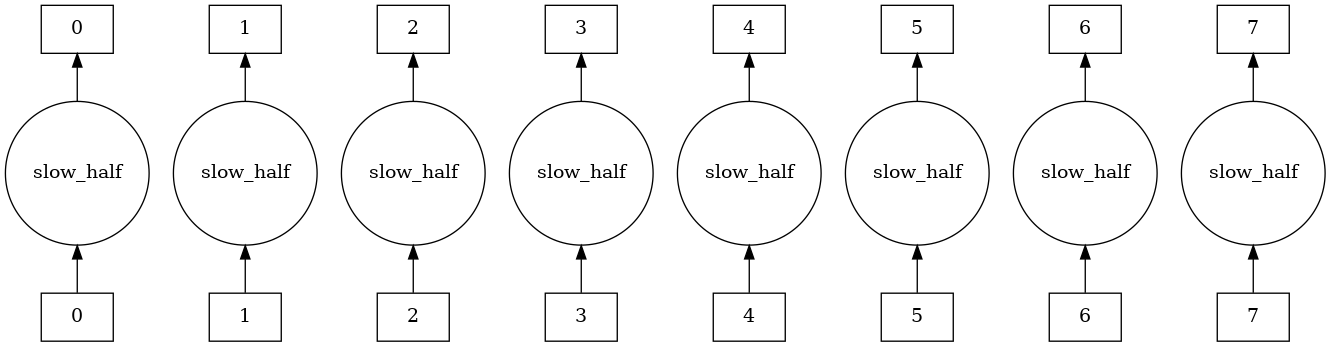

In [ ]:
res.visualize()

In [ ]:
b.product(b).compute() # Cartesian product of each pair 
# of elements in two sequences (or the same sequence in this case)

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8)]

Chain operations to construct more complex computations

In [ ]:
(b.filter(lambda x: x % 2 > 0)
  .product(b)
  .filter( lambda v : v[0] % v[1] == 0 and v[0] != v[1])
  .compute())

[(3, 1), (5, 1), (7, 1)]

## Daily stock example

Let's use the bag interface to read the json files containing time series.

Each line is a JSON encoded dictionary with the following keys
- timestamp: Day.
- close: Stock value at the end of the day.
- high: Highest value.
- low: Lowest value.
- open: Opening price.

In [ ]:
# preparing data
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where,name)
    if not os.path.exists(datadir):
       print("Extracting data...")
       tar_path = os.path.join(where, name+'.tgz')
       with tarfile.open(tar_path, mode='r:gz') as data:
          data.extractall(where)
            
extract_data('daily-stock','data') # this function call will extract json files

In [ ]:
%ls data/daily-stock/*.json

data/daily-stock/aet.json   data/daily-stock/hpq.json
data/daily-stock/afl.json   data/daily-stock/ibm.json
data/daily-stock/aig.json   data/daily-stock/jbl.json
data/daily-stock/al.json    data/daily-stock/jpm.json
data/daily-stock/amgn.json  data/daily-stock/luv.json
data/daily-stock/avy.json   data/daily-stock/met.json
data/daily-stock/b.json     data/daily-stock/pcg.json
data/daily-stock/bwa.json   data/daily-stock/tgt.json
data/daily-stock/ge.json    data/daily-stock/usb.json
data/daily-stock/hal.json   data/daily-stock/xom.json
data/daily-stock/hp.json


In [ ]:
import dask.bag as db
import json
stocks = db.read_text('data/daily-stock/*.json')

In [ ]:
stocks.npartitions

22

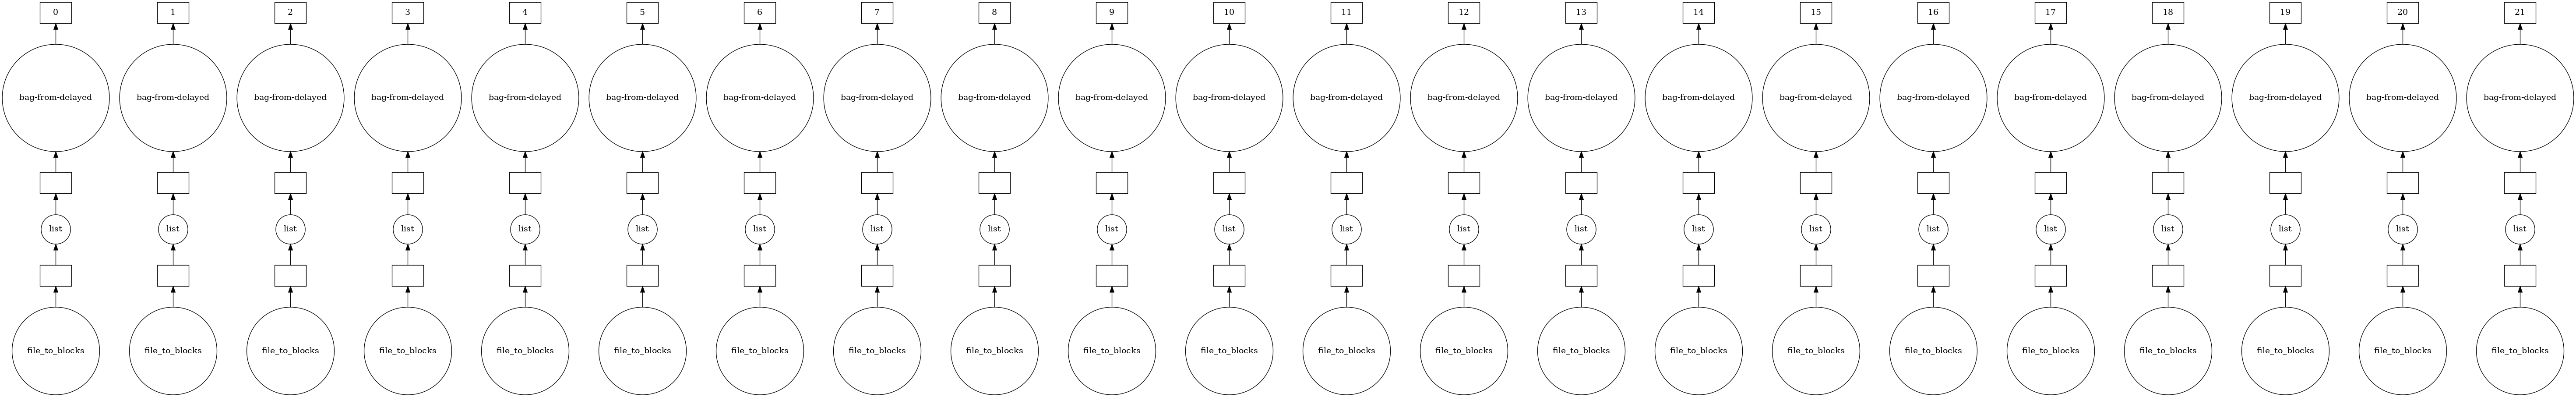

In [ ]:
stocks.visualize()

In [ ]:
import json
js = stocks.map(json.loads)

In [ ]:
import os, sys
from glob import glob
import pandas as pd
import json

here = os.getcwd() # get the current directory
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.json')))
filenames

['/home/jovyan/work/data/daily-stock/aet.json',
 '/home/jovyan/work/data/daily-stock/afl.json',
 '/home/jovyan/work/data/daily-stock/aig.json',
 '/home/jovyan/work/data/daily-stock/al.json',
 '/home/jovyan/work/data/daily-stock/amgn.json',
 '/home/jovyan/work/data/daily-stock/avy.json',
 '/home/jovyan/work/data/daily-stock/b.json',
 '/home/jovyan/work/data/daily-stock/bwa.json',
 '/home/jovyan/work/data/daily-stock/ge.json',
 '/home/jovyan/work/data/daily-stock/hal.json',
 '/home/jovyan/work/data/daily-stock/hp.json',
 '/home/jovyan/work/data/daily-stock/hpq.json',
 '/home/jovyan/work/data/daily-stock/ibm.json',
 '/home/jovyan/work/data/daily-stock/jbl.json',
 '/home/jovyan/work/data/daily-stock/jpm.json',
 '/home/jovyan/work/data/daily-stock/luv.json',
 '/home/jovyan/work/data/daily-stock/met.json',
 '/home/jovyan/work/data/daily-stock/pcg.json',
 '/home/jovyan/work/data/daily-stock/tgt.json',
 '/home/jovyan/work/data/daily-stock/usb.json',
 '/home/jovyan/work/data/daily-stock/xom.jso

In [ ]:
!rm data/daily-stock/*.h5

In [ ]:
from tqdm import tqdm
for fn in tqdm(filenames):
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')

In [ ]:
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.h5')))
filenames

['/home/jovyan/work/data/daily-stock/aet.h5',
 '/home/jovyan/work/data/daily-stock/afl.h5',
 '/home/jovyan/work/data/daily-stock/aig.h5',
 '/home/jovyan/work/data/daily-stock/al.h5',
 '/home/jovyan/work/data/daily-stock/amgn.h5',
 '/home/jovyan/work/data/daily-stock/avy.h5',
 '/home/jovyan/work/data/daily-stock/b.h5',
 '/home/jovyan/work/data/daily-stock/bwa.h5',
 '/home/jovyan/work/data/daily-stock/ge.h5',
 '/home/jovyan/work/data/daily-stock/hal.h5',
 '/home/jovyan/work/data/daily-stock/hp.h5',
 '/home/jovyan/work/data/daily-stock/hpq.h5',
 '/home/jovyan/work/data/daily-stock/ibm.h5',
 '/home/jovyan/work/data/daily-stock/jbl.h5',
 '/home/jovyan/work/data/daily-stock/jpm.h5',
 '/home/jovyan/work/data/daily-stock/luv.h5',
 '/home/jovyan/work/data/daily-stock/met.h5',
 '/home/jovyan/work/data/daily-stock/pcg.h5',
 '/home/jovyan/work/data/daily-stock/tgt.h5',
 '/home/jovyan/work/data/daily-stock/usb.h5',
 '/home/jovyan/work/data/daily-stock/xom.h5']

### Serial version

In [ ]:
%%time
series = {}
for fn in filenames:   # Simple map over filenames
    series[fn] = pd.read_hdf(fn)['close']

results = {}

for a in filenames:    # Doubly nested loop over the same collection
    for b in filenames:  
        if a != b:     # Filter out bad elements
            results[a, b] = series[a].corr(series[b])  # Apply function

((a, b), corr) = max(results.items(), key=lambda kv: kv[1])  # Reduction

CPU times: user 1.91 s, sys: 872 ms, total: 2.79 s
Wall time: 2.96 s


In [ ]:
a, b, corr

('/home/jovyan/work/data/daily-stock/aet.h5',
 '/home/jovyan/work/data/daily-stock/luv.h5',
 0.9413176064560879)

## Dask.bag methods

We can construct most of the above computation with the following dask.bag methods:

*  `collection.map(function)`: apply function to each element in collection
*  `collection.product(collection)`: Create new collection with every pair of inputs
*  `collection.filter(predicate)`: Keep only elements of colleciton that match the predicate function
*  `collection.max()`: Compute maximum element

In [ ]:
%%time

import dask.bag as db

b = db.from_sequence(filenames)
series = b.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.product(series)
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1])).max())

CPU times: user 10.4 ms, sys: 27.4 ms, total: 37.8 ms
Wall time: 38.3 ms


In [ ]:
%%time

result = corr.compute()

CPU times: user 5.81 s, sys: 9.62 s, total: 15.4 s
Wall time: 31 s


In [ ]:
result

0.9413176064560879

### Wordcount with Dask bag

In [ ]:
import lorem

for i in range(20):
    with open(f"sample{i:02d}.txt","w") as f:
        f.write(lorem.text())

In [ ]:
%ls *.txt

requirements.txt  sample04.txt  sample09.txt  sample14.txt  sample19.txt
sample00.txt      sample05.txt  sample10.txt  sample15.txt  sample.txt
sample01.txt      sample06.txt  sample11.txt  sample16.txt
sample02.txt      sample07.txt  sample12.txt  sample17.txt
sample03.txt      sample08.txt  sample13.txt  sample18.txt


In [ ]:
import glob
glob.glob('sample*.txt')

['sample.txt',
 'sample11.txt',
 'sample17.txt',
 'sample08.txt',
 'sample15.txt',
 'sample03.txt',
 'sample18.txt',
 'sample14.txt',
 'sample19.txt',
 'sample09.txt',
 'sample06.txt',
 'sample01.txt',
 'sample00.txt',
 'sample07.txt',
 'sample16.txt',
 'sample10.txt',
 'sample13.txt',
 'sample05.txt',
 'sample12.txt',
 'sample02.txt',
 'sample04.txt']

In [ ]:
import dask.bag as db
import glob
b = db.read_text(glob.glob('sample*.txt'))

wordcount = (b.str.replace(".","")  # remove dots
             .str.lower()           # lower text
             .str.strip()           # remove \n and trailing spaces
             .str.split()           # split into words
             .flatten()             # chain all words lists
             .frequencies()         # compute occurences
             .topk(10, lambda x: x[1])) # sort and return top 10 words


wordcount.compute() # Run all tasks and return result

[('dolor', 187),
 ('etincidunt', 186),
 ('adipisci', 179),
 ('tempora', 176),
 ('voluptatem', 176),
 ('non', 175),
 ('velit', 171),
 ('ut', 171),
 ('amet', 170),
 ('modi', 168)]

## Genome example
We will use a Dask bag to calculate the frequencies of sequences of five bases, and then sort the sequences into descending order ranked by their frequency.

- First we will define some functions to split the bases into sequences of a certain size

### Exercise 9.1

- Implement a function `group_characters(line, n=5)` to group `n` characters together and return a iterator. `line` is a text line in genome.txt file.

```py
>>> line = "abcdefghijklmno"
>>> for seq in group_character(line, 5):
        print(seq)
        
"abcde"
"efghi"
"klmno"
```

    
- Implement `group_and_split(line)`
```py
>>> group_and_split('abcdefghijklmno')
['abcde', 'fghij', 'klmno']
```

- Use the dask bag to compute  the frequencies of sequences of five bases.

In [ ]:
def group_character( line, n=5):
    bases = ''
    for i, b in enumerate(line):
        bases += b
        if (i+1) % n == 0:
            yield bases
            bases = ''

In [ ]:
line = "abcdefghijklmno"
for seq in group_character(line, 5):
    print(seq)

abcde
fghij
klmno


In [ ]:
def group_and_split( line, n=5):
    return [seq for seq in group_character(line,n)]

In [ ]:
group_and_split('abcdefghijklmno')

['abcde', 'fghij', 'klmno']

In [ ]:
import os
from glob import glob

data_path = os.path.join("data")
with open(os.path.join(data_path,"genome.txt")) as g:
    data = g.read()
    for i in range(8):
        file = os.path.join(data_path,f"genome{i:02d}.txt")
        with open(file,"w") as f:
            f.write(data)

glob("data/genome0*.txt")

['data/genome02.txt',
 'data/genome01.txt',
 'data/genome05.txt',
 'data/genome04.txt',
 'data/genome00.txt',
 'data/genome07.txt',
 'data/genome06.txt',
 'data/genome03.txt']

### Exercise 9.2

The [FASTA](http://www.cbs.dtu.dk/services/NetGene2/fasta.php) file format is used to write several genome sequences.

- Create a function that can read a [FASTA file](data/nucleotide-sample.txt) and compute the frequencies for n = 5 of a given sequence.

In [ ]:
from operator import itemgetter

genome = 'data/genome.txt'

def read_fasta(genome):
    with open(genome) as f:
        data = f.readlines()
 
    res = dict()
    for line in data:
        for key in group_and_split(line):
            try:
                res[key] += 1
            except KeyError:
                res[key] = 1

    return dict(sorted(res.items(), key=itemgetter(1), reverse=True)[:10])

read_fasta(genome)

{'CTGTG': 59,
 'CCCAG': 55,
 'CCTGG': 52,
 'AAAAA': 49,
 'TGCTG': 42,
 'TGTGT': 41,
 'CCACC': 39,
 'GGCTG': 38,
 'CACCA': 37,
 'GGTGG': 37}

In [ ]:
%%file testset.fasta

>SEQUENCE_1
MTEITAAMVKELRESTGAGMMDCKNALSETNGDFDKAVQLLREKGLGKAAKKADRLAAEG
LVSVKVSDDFTIAAMRPSYLSYEDLDMTFVENEYKALVAELEKENEERRRLKDPNKPEHK
IPQFASRKQLSDAILKEAEEKIKEELKAQGKPEKIWDNIIPGKMNSFIADNSQLDSKLTL
MGQFYVMDDKKTVEQVIAEKEKEFGGKIKIVEFICFEVGEGLEKKTEDFAAEVAAQL
>SEQUENCE_2
SATVSEINSETDFVAKNDQFIALTKDTTAHIQSNSLQSVEELHSSTINGVKFEEYLKSQI
ATIGENLVVRRFATLKAGANGVVNGYIHTNGRVGVVIAAACDSAEVASKSRDLLRQICMH

Writing testset.fasta


### Exercise 9.3

Write a program that uses the function implemented above to read several FASTA files stored in a Dask bag.

In [ ]:
%cat data/genome.txt

GATCAATGAGGTGGACACCAGAGGCGGGGACTTGTAAATAACACTGGGCTGTAGGAGTGA
TGGGGTTCACCTCTAATTCTAAGATGGCTAGATAATGCATCTTTCAGGGTTGTGCTTCTA
TCTAGAAGGTAGAGCTGTGGTCGTTCAATAAAAGTCCTCAAGAGGTTGGTTAATACGCAT
GTTTAATAGTACAGTATGGTGACTATAGTCAACAATAATTTATTGTACATTTTTAAATAG
CTAGAAGAAAAGCATTGGGAAGTTTCCAACATGAAGAAAAGATAAATGGTCAAGGGAATG
GATATCCTAATTACCCTGATTTGATCATTATGCATTATATACATGAATCAAAATATCACA
CATACCTTCAAACTATGTACAAATATTATATACCAATAAAAAATCATCATCATCATCTCC
ATCATCACCACCCTCCTCCTCATCACCACCAGCATCACCACCATCATCACCACCACCATC
ATCACCACCACCACTGCCATCATCATCACCACCACTGTGCCATCATCATCACCACCACTG
TCATTATCACCACCACCATCATCACCAACACCACTGCCATCGTCATCACCACCACTGTCA
TTATCACCACCACCATCACCAACATCACCACCACCATTATCACCACCATCAACACCACCA
CCCCCATCATCATCATCACTACTACCATCATTACCAGCACCACCACCACTATCACCACCA
CCACCACAATCACCATCACCACTATCATCAACATCATCACTACCACCATCACCAACACCA
CCATCATTATCACCACCACCACCATCACCAACATCACCACCATCATCATCACCACCATCA
CCAAGACCATCATCATCACCATCACCACCAACATCACCACCATCACCAACACCACCATCA
CCACCACCACCACCATCATCACCACCACCACCATCATCATCACCACCACCGCCATCATCA
TCGCCACCACCATGACCACCACCA

In [ ]:
from operator import itemgetter
 
import dask.bag as db
 
b = db.read_text("data/genome0*.txt")
 
result = (b.filter(lambda line: not line.startswith(">"))
  .map(lambda line: line.strip())
  .map(lambda line : group_and_split(line,5))
  .flatten()
  .frequencies()
  .topk(10,lambda v : v[1]))


result.compute()

[('CTGTG', 472),
 ('CCCAG', 440),
 ('CCTGG', 416),
 ('AAAAA', 392),
 ('TGCTG', 336),
 ('TGTGT', 328),
 ('CCACC', 312),
 ('GGCTG', 304),
 ('CACCA', 296),
 ('GGTGG', 296)]

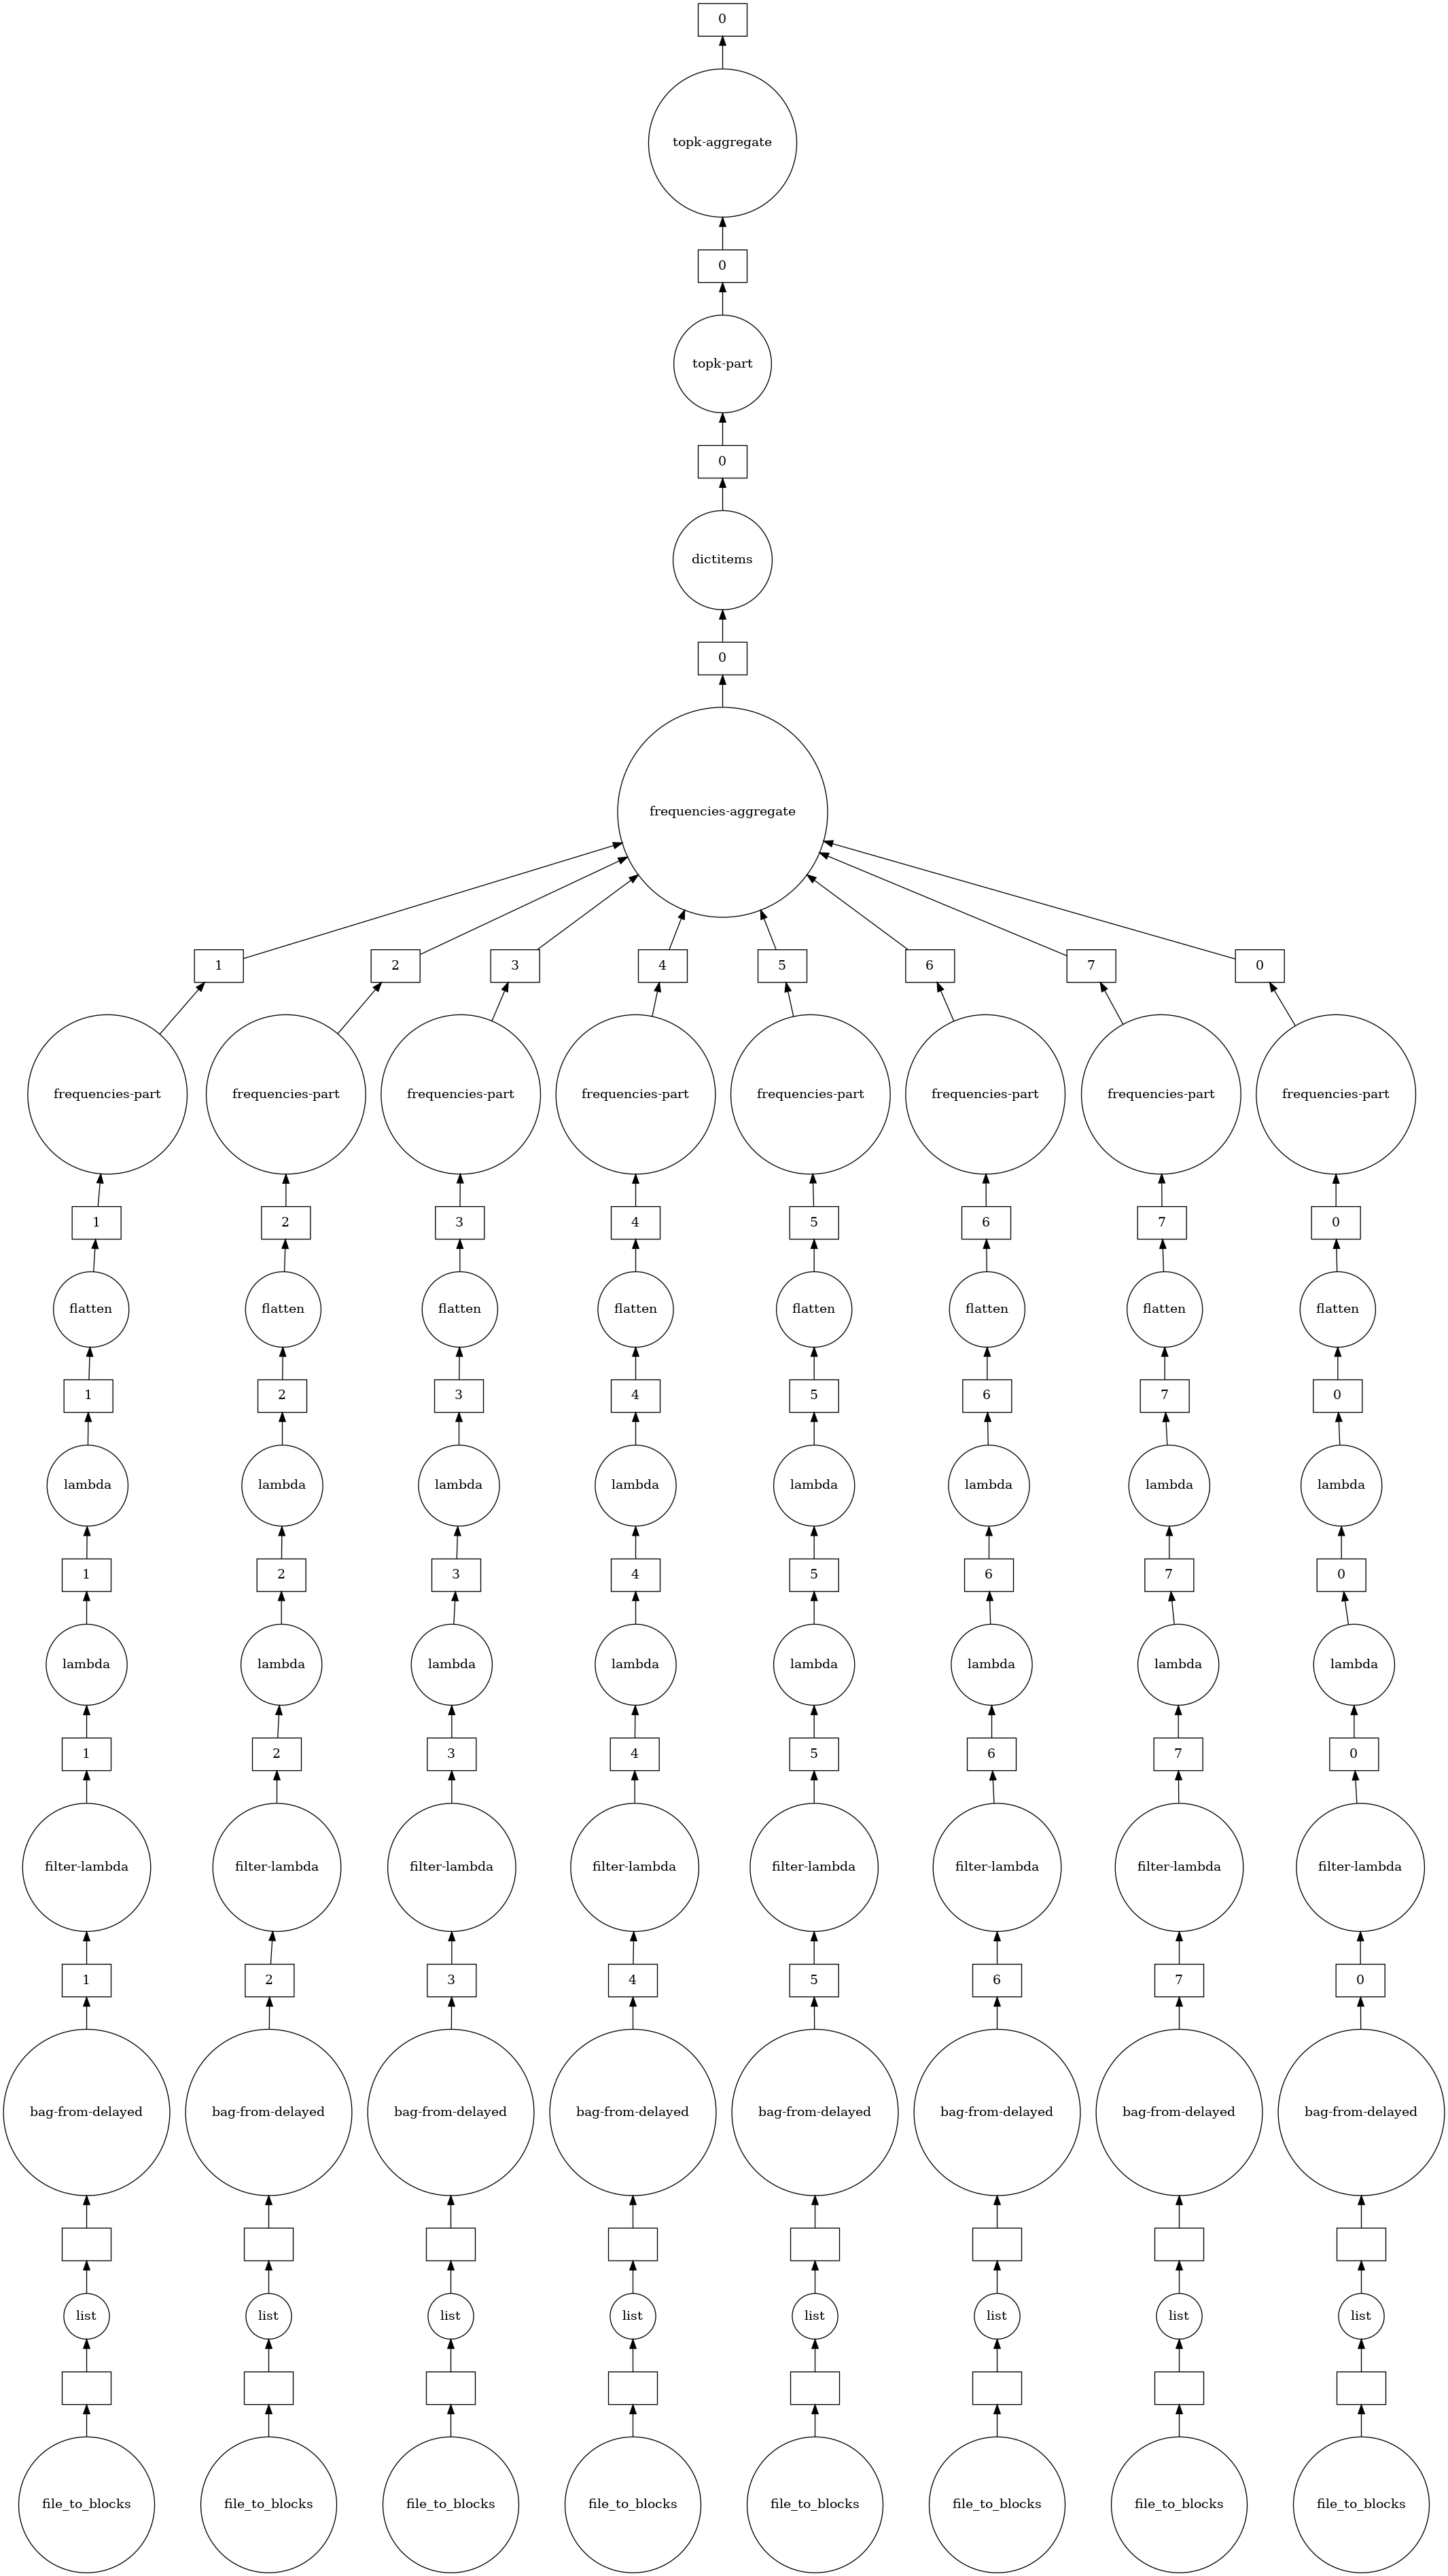

In [ ]:
result.visualize()

## Some remarks about bag

*  Higher level dask collections include functions for common patterns
*  Move data to collection, construct lazy computation, trigger at the end
*  Use Dask.bag (`product + map`) to handle nested for loop

Bags have the following known limitations

1.  Bag operations tend to be slower than array/dataframe computations in the
    same way that Python tends to be slower than NumPy/Pandas
2.  ``Bag.groupby`` is slow.  You should try to use ``Bag.foldby`` if possible.
    
3. Check the [API](http://dask.pydata.org/en/latest/bag-api.html) 

4. `dask.dataframe` can be faster than `dask.bag`.  But sometimes it is easier to load and clean messy data with a bag. We will see later how to transform a bag into a `dask.dataframe` with the [to_dataframe](http://dask.pydata.org/en/latest/bag-api.html#dask.bag.Bag.to_dataframe) method.